In [ ]:
# Import những thư viện cần thiết
import re
import nltk
import string 
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from nltk import pos_tag
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from string import punctuation
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Read data
file_data = r'drive/My Drive/Colab Notebooks/data/fake_job_postings.csv'
df = pd.read_csv(file_data)

In [ ]:
# Xem dữ liệu đầu tiên (mặc định là 5 dòng đầu tiên)
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editor...","Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small te...","Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooki...",NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produce...",Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jets...,"What we expect from you:Your key responsibility will be to communicate with the client, 90 Seconds team and freelance community throughout the video production process including, shoot planning, s...",What you will get from usThrough being part of the 90 Seconds team you will gain:experience working on projects located around the world with an international brandexperience working with a variet...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,"Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry. Valor Services will be involved with you...","Our client, located in Houston, is actively seeking an experienced Commissioning Machinery Assistant that possesses strong supervisory skills and has an attention to detail. A strong dedication to...",Implement pre-commissioning and commissioning procedures for rotary equipment.Execute all activities with subcontractor’s assigned crew that pertains to the discipline.Ensure effective utilization...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,"Our passion for improving quality of life through geography is at the heart of everything we do. Esri’s geographic information system (GIS) technology inspires and enables governments, universiti...",THE COMPANY: ESRI – Environmental Systems Research InstituteOur passion for improving quality of life through geography is at the heart of everything we do. Esri’s geographic information system (...,"EDUCATION: Bachelor’s or Master’s in GIS, business administration, or a related field, or equivalent work experience, depending on position levelEXPERIENCE: 5+ years of enterprise sales experience...","Our culture is anything but corporate—we have a collaborative, creative environment; phone directories organized by first name; a relaxed dress code; and open-door policies.A Place to ThrivePassio...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,"SpotSource Solutions LLC is a Global Human Capital Management Consulting firm headquartered in Miami, Florida. Founded in January 2012, SpotSource has created a fusion of innovative service offeri...","JOB TITLE: Itemization Review ManagerLOCATION: Fort Worth, TX DEPARTMENT: Itemization ReviewREPORTS TO: VP Operations ...","QUALIFICATIONS:RN license in the State of TexasDiploma or Bachelors of Sci

### Data Inspection

In [ ]:
# Xem 10 giá trị đầu tiên của biến target fraudulent = 1 (lừa đảo) 
df[df['fraudulent'] == 1].head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically gra...,"IC&amp;E Technician | Bakersfield, CA Mt. PosoPrincipal Duties and Responsibilities: Calibrates, tests, maintains, troubleshoots, and installs all power plant instrumentation, control systems and ...","QualificationsKnowledge, Skills &amp; Abilities: A high school diploma or GED is required. Must have a valid driver’s license. Ability to read, write, and communicate effectively in English. Good...",BENEFITSWhat is offered:Competitive compensation package100% matched retirement fundAnnual vacations paid for by companySignificant bonus structureOpportunity for advancement Full benefits package...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase of homes in the Southeast. The student on this project will help them build their investments from the ground up and will help with the analysis and mo...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
173,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model. Our focus is to help develop...,"Technician Instrument &amp; ControlsLocation Deweyville, TXLocation Name: NRG Cottonwood EnergyCategory: MaintenanceState/City: US-TX-DeweyvilleType: Full Time Hourly# Openings: 1Details About thi...",JOB QUALIFICATIONS-Ability to understand procedures and instructions specific to the area of assignment as would be acquired in four years of high school.-Graduation from an accredited Instrument ...,"we are a team of almost 8,000 employees who help power almost 40 million homes and have more than 2 million residential and business customers across the country. Together, we are powering progres...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1
180,181,Sales Executive,"PK, SD, Karachi",Sales,NaN,NaN,Sales Executive,Sales Executive,Sales Executive,0,0,0,NaN,NaN,NaN,NaN,Sales,1
215,216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically gra...,"IC&amp;E Technician | Bakersfield, CA Mt. PosoPrincipal Duties and Responsibilities: Calibrates, tests, maintains, troubleshoots, and installs all power plant instrumentation, control systems and ...","QualificationsKnowledge, Skills &amp; Abilities: A high school diploma or GED is required. Must have a valid driver’s license. Ability to read, write, and communicate effectively in English. Goo...",BENEFITSWhat is offered:Competitive compensation package100% matched retirement fundAnnual vacations paid for by companySignificant bonus structureOpportunity for advancement Full benefits package...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
357,358,Financing Auto(car) sales,"US, IL, hazelcrest",hr,35000-73000,Looking for adventurous people to join a thriving industry. We offer training and competitive earnings. Find out why imports are the way to go and view our cars at our website.,If you have experience in financing for auto sales and a great attitude you can work in our Hazelcrest office. From $500 top $1000 a week by contract.,prior car sales expprior car loan financing exp,profit sharingcar allowancecompany car,0,0,0,Contract,Associate,NaN,Automotive,NaN,1
493,494,Admin Assistant/ Receptionist,"US, CA, Los Angeles",NaN,23040-28800,NaN,"A Newly established compan

In [ ]:
# Xem 10 giá trị đầu tiên của biến target fraudulent = 0 (không lừa đảo) 
df[df['fraudulent'] == 0].head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editor...","Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small te...","Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooki...",NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produce...",Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jets...,"What we expect from you:Your key responsibility will be to communicate with the client, 90 Seconds team and freelance community throughout the video production process including, shoot planning, s...",What you will get from usThrough being part of the 90 Seconds team you will gain:experience working on projects located around the world with an international brandexperience working with a variet...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,"Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry. Valor Services will be involved with you...","Our client, located in Houston, is actively seeking an experienced Commissioning Machinery Assistant that possesses strong supervisory skills and has an attention to detail. A strong dedication to...",Implement pre-commissioning and commissioning procedures for rotary equipment.Execute all activities with subcontractor’s assigned crew that pertains to the discipline.Ensure effective utilization...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,"Our passion for improving quality of life through geography is at the heart of everything we do. Esri’s geographic information system (GIS) technology inspires and enables governments, universiti...",THE COMPANY: ESRI – Environmental Systems Research InstituteOur passion for improving quality of life through geography is at the heart of everything we do. Esri’s geographic information system (...,"EDUCATION: Bachelor’s or Master’s in GIS, business administration, or a related field, or equivalent work experience, depending on position levelEXPERIENCE: 5+ years of enterprise sales experience...","Our culture is anything but corporate—we have a collaborative, creative environment; phone directories organized by first name; a relaxed dress code; and open-door policies.A Place to ThrivePassio...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,"SpotSource Solutions LLC is a Global Human Capital Management Consulting firm headquartered in Miami, Florida. Founded in January 2012, SpotSource has created a fusion of innovative service offeri...","JOB TITLE: Itemization Review ManagerLOCATION: Fort Worth, TX DEPARTMENT: Itemization ReviewREPORTS TO: VP Operations ...","QUALIFICATIONS:RN license in the State of TexasDiploma or Bachelors of Sci

In [ ]:
# Xem hình dạng của dataframe
df.shape

(17880, 18)

In [ ]:
# Thống kê có bao nhiêu bài Post là lừa đảo / không lừa đảo
df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

### Data Cleaning

In [ ]:
# Kiểm tra giá trị NULL
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Drop đi những thuộc tính không sử dụng. Do đây là bài toán text classification
df.drop(['job_id', 'salary_range','telecommuting', 'has_company_logo','has_questions'], axis=1, inplace =True)

In [ ]:
# Thay thế giá trị NaN thành ' '
df.fillna(' ', inplace=True)

In [ ]:
# Kiểm tra lại giá trị NULL
df.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [ ]:
# Thực hiện nối giá trị các thuộc tính lại với nhau và lưu trữ tại thuộc tính 'text'
df['text'] = df['title'] + ' '+ df['location']+' ' + df['department']+ ' '+df['company_profile']+ ' '+df['description']+ ' '+\
df['requirements']+ ' '+df['benefits']+' '+df['employment_type']+' '+df['required_experience']+' '+\
df['required_education']+' '+df['industry']+' '+df['function']

In [ ]:
# Drop đi những thuộc tính vừa mới nối lại bên trên
df.drop(['title', 'location', 'department', 'company_profile', 'description', 'required_experience','requirements', 'benefits', 'employment_type','required_education','industry','function'], inplace=True, axis=1)

In [ ]:
# Review lại DF
df.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything..."
1,0,"Customer Service - Cloud Video Production NZ, , Auckland Success 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and a..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA, Wever Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp..."
3,0,"Account Executive - Washington DC US, DC, Washington Sales Our passion for improving quality of life through geography is at the heart of everything we do. Esri’s geographic information system (G..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSource Solutions LLC is a Global Human Capital Management Consulting firm headquartered in Miami, Florida. Founded in January 2012, SpotSource has crea..."


In [ ]:
# Hàm dùng để xóa các pattern và thay thế bằng ''
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(re.escape(i), '', input_txt)
    return input_txt

In [ ]:
# Loại bỏ những đường link
df['tidy_text'] = np.vectorize(remove_pattern)(df['text'], 'http\S+')

In [ ]:
# Loại bỏ \xa0
df['tidy_text'] = np.vectorize(remove_pattern)(df['tidy_text'], '\xa0')

In [ ]:
df['tidy_text'] = np.vectorize(remove_pattern)(df['tidy_text'], '#\S+')

In [ ]:
# Loại bỏ tất cả các kí tự dư thừa ngoài trừ bảng chữ cái thường và hoa
df.tidy_text = df.tidy_text.str.replace("[^a-zA-Z]", ' ')

In [ ]:
# Loại bỏ những khoảng trống thừa
df['tidy_text'] = df['tidy_text'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Loại bỏ những từ có ít hơn 3 ký tự
df['tidy_text'] = df['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [ ]:
# Tokenize 1 kí tự
tokenized_text= df['tidy_text'].apply(lambda x: x.split())

In [ ]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#### POS - Part of Speech là việc phân loại các từ trong một câu (danh từ, trạng từ, tính từ hay động tự,...)
Link tham khảo: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [ ]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### Trong quá trình xử lý ngôn ngữ tự nhiên, chúng ta sẽ có nhu cầu so sánh các token (các từ) với nhau. Đối với dữ liệu của chúng ta là tiếng anh, mỗi từ sẽ có nhiều biến thể khác nhau (ví dụ: 'plays', 'playes', 'playing', 'played' đều là các biến thể của từ 'play') dẫn đến việc so sánh các từ với nhau là không thể mặc dù về mặt ý nghĩa cơ bản là như nhau.
#### Vậy làm sao để so sánh các từ như thế với nhau?
##### Ta có 2 kỹ thuật thường dùng cho việc này là Stemming và Lemmatization. Ở đồ án môn học này,  nhóm tác giả sẽ sử dụng Lemmatization.

### Giới thiệu về Stemming: là kỹ thuật dùng để biến đổi 1 từ về dạng gốc bằng cách loại bỏ 1 số ký tự nằm cuối - những ký từ mà nó nghĩ là biến thể của từ. Nhưng đôi khi kết quả Stem không đưược như ta mong muốn. Chẳng hạn từ 'goes' sau khi stem sẽ thành 'goe', trong khi stem của 'go' vẫn là 'go' => Kết quả là 2 từ 'go' và 'goes' sau khi stem không giống nhau. Một nhược điểm khác nữa là các từ bất quy tắc là 'went' thì stemming sẽ không đưa các từ này về dạng gốc là 'go'.

### Giới thiệu về Lemmatization: Lemmatization sẽ xử lý thông minh hơn bằng một bộ từ điển hoặc một bộ ontology nào đó. Điều này đảm bảo rằng các từ 'went', 'goes' và 'go' sẽ chắc chắn có kết quả trả về là như nhau.

In [ ]:
# Tạo hàm để phục vụ thực hiện quá trình lemmatization 
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    #Tạo list để chứa từ sau khi xử lý xong
    final_text = []
    # Lấy từng từ trong text ra
    for i in text.split():
        # Loại bỏ khoảng trống 2 bên, chuyển về lower và nếu từ lấy ra không nằm trong STOPWORD. 
        if i.strip().lower() not in stop:
            # xác định POS cho từng từ 
            pos = pos_tag([i.strip()])
            #Tiến hành lemmatization
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            # Nối từ vào list
            final_text.append(word.lower())
    return " ".join(final_text)

In [ ]:
# Apply
df.tidy_text = df.tidy_text.apply(lemmatize_words)

# Nhược điiểm của lemmatization là tốc độ xử lý khá chậm vì phải truy cứu từ trong cơ sở dữ liệu.
# Trong các ứng dụng xử lý NLP mà cần độ chính xác cao hơn và thời gian không quan trọng thì ta sẽ sử dụng Lemmatization thay vì Stemming

In [ ]:
# Tạo/nối chuỗi các từ trong fraudulent = 1
unnormal_words = ' '.join([text for text in df['tidy_text'][df['fraudulent']==1]])

In [ ]:
# Tạo Wordcloud
word_cloud= WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(unnormal_words)

(-0.5, 799.5, 499.5, -0.5)

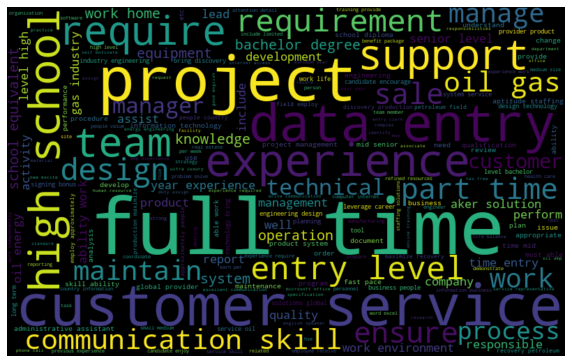

In [ ]:
# Biểu diễn wordcloud trên biểu đồ
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
# Tạo/nối chuỗi các từ trong fraudulent = 0
real_words = ' '.join([text for text in df['tidy_text'][df['fraudulent']==0]])

In [ ]:
# Tạo Wordcloud
word_cloud= WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(real_words)

(-0.5, 799.5, 499.5, -0.5)

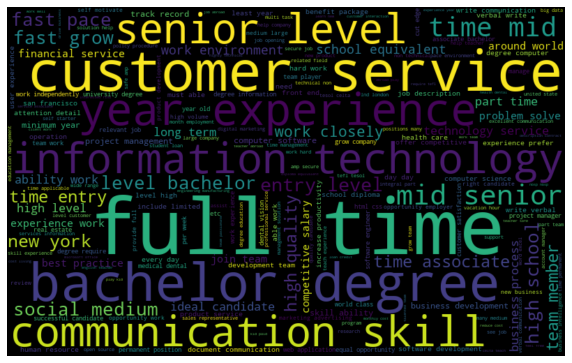

In [ ]:
# Biểu diễn wordcloud trên biểu đồ
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
#Xem số lượng dữ liệu
df.shape

(17880, 3)

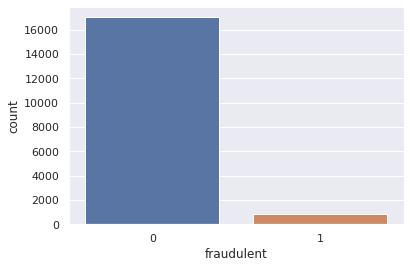

In [ ]:
#Biểu diễn số lượng các bài tuyển dụng vào các nhãn
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = df)

### ===>Nhìn vào biểu đồ ta thấy, dữ liệu bị mất cân bằng trầm trọng. Có 95% dữ liệu thuộc lớp 1, và chỉ có 5% thuộc lớp 0

### Các phương pháp giải quyết mất cân bằng

#### 1. Thay đổi metric:
Do dữ liệu mất cân bằng thì việc sử dụng độ đo accuracy thường sẽ không hiệu quả. Vì một mô hình ngẫu nhiên dự đoán toàn bộ là nhãn thuộc nhóm đa số sẽ cho kết quả rất cao - gần bằng 100%. Do đó, ta có thể cân nhắc tới một số metric thay thế như precision, recall, f1-score, auc,... Các chỉ số này không quá lớn để dẫn tới sự ngộ nhận độ chính xác, đồng thời chúng tập trung hơn vào việc đánh giá độ chính xác của nhóm thiểu số - nhóm mà ta muốn dự báo chính xác hơn là nhóm đa số.
Trong bài tooán này ta sẽ sử dụng độ đo f1-score

#### 2. Thay đổi thuật toán
Trong nhiều vấn đề khai thác dữ liệu, nó thì tốt cho chúng ta khi thử nhiều thuật tooán khác nhau cho dữ liệu. Nó đặt biệc có hiệu quả với những dữ liệu mất cân bằng.
Đối với phạm vi đồ án môn học này, nhóm tác giả sẽ sử dụng 3 thuật toán:
1. Logistic Regression
2. SVM
3. Random Forest

#### 3. Under Sampling
Under Sampling là việc giảm số lượng quan sát của nhóm đa số để nó trở nnê cân bằng với số quan sát của nhóm thiểu số. 
- Ưu điểm của under sampling là làm cân bằng mẫu một cách nhanh chống, dễ dàng tiến hành mà không cần đến thuật toán giả lập mẫu.
- Nhược điểm là giảm số lượng mẫu một cách đáng kể, dẫn đến tập huấn luyện mới khá nhỏ dễ dẫn đến tình trạng overfiting.

In [ ]:
from sklearn.utils import resample

In [ ]:
not_fraud_downsampled  = resample(df[df.fraudulent == 0], replace = False, n_samples = len(df[df.fraudulent == 1]), random_state=27)
downsampled  = pd.concat([not_fraud_downsampled, df[df.fraudulent == 1]])

In [ ]:
downsampled.fraudulent.value_counts()

1    866
0    866
Name: fraudulent, dtype: int64

#### 4. Over Sampling
Over Sampling là các phương pháp giúp giải quyết hiện tượng mất cân bằng mẫu bằng cách gia tăng kích thước mẫu thuộc nhóm thiểu số bằng các kỹ thuật khác nhau. Ở đây chúng ta sẽ sử dụng 2 phương pháp:
1. SMOTE - Synthetic Minority Oversampling Technique
2. ADASYN - Adaptive synthetic sampling

Cả SMOTE và ADASYN là các phương pháp sinh mẫu nhằm tăng kích thước mẫu của nhóm thiểu số trong trường hợp xảy ra mất cân bằng mẫu.
Trong đồ án môn học này, nhóm tác giả sẽ sử dụng SMOTE, ADASYN thực hiện tương tự.

###  Đối với Neural network sau khi chuẩn hóa dữ liệu chúng ta sẽ ánh xạ từng input text đầu vào thành một vector từ để làm input cho mạng. Thông thường chúng ta có 2 lựa chọn:
- Xem mỗi từ là 1 token nghĩa là chúng ta sẽ tạo ra 2 bộ từ vựng (Một chuyển đổi từ từ vựng sang số, một chuyển số tương ứng sang từ vựng). Tuy nhiên sẽ có những từ ít xuất hiện khiến cho từ điển vô cùng lớn. Để giải quyết chúng ta sẽ tạo ra token UNK – tương ứng với những từ có tần suất xuất hiện ít. Bây giờ input của mạng neural chúng ta là vector tokens sau đó sẽ được khởi tạo thành những vector số ngẫu nhiên và được đào tạo chung thông qua mạng neural.
- Word Embedding: Chúng ta sẽ ánh xạ các từ trong bộ từ vựng thành một  vector số thực có n chiều bằng cách dùng mô hình Bag of words, Skip gram hoặc có thể dùng word vector đã được train sẵn như Glove. Những từ có chung ngữ cảnh(king – queen) sẽ gần nhau trong không gian vector hơn những từ có ngữ cảnh khác biệt nhau (King-table). Các vector từ được biểu diễn theo phương pháp này thể hiện được ngữ nghĩa của các từ. Từ đó chúng ta có thể nhận ra mối quan hệ giữa các từ với nhau.
- Trong bài này, nhóm tác giả sẽ dùng phương pháp 1 tạo ra các vector tokens làm input đầu vào


### Để phân tích dữ liệu đã được xử lý bên trên, ta cần chuyển sang thành các feature. Tùy thuộc vào các sử dụng, các text feature có thể được xây dưng bằng các kỹ thuật như Bag of Words, TF-IDF và Word Embeddings

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. 
The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. 
Each row in the matrix M contains the frequency of tokens in document D(i).

Example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –
    He   She   lazy   boy   Smith   person
D1  1     1     2      1      0        0
D2  0     0     1      0      1     1

In [ ]:
#min_df =2 loại bỏ những từ có lần xuất hiện bé hơn bằng 2 trong documents của text
#max_df = 0.9 loại bỏ những từ xuất hiện lớn hơn 90%
bow_vectorizer = CountVectorizer(max_df=0.9, min_df=2)

### TF-IDF là một phương pháp khác dựa trên phương pháp tần suất. Nhưng khác với cách tiếp cận của BOW, nó không chỉ tính đến sự xuất hiện của một từ trong 1 documents mà là toàn bộ corpus.
### TF-IDF hooạt động bằng cách xử phạt các từ phổ biến bằng cách gán cho chúng trọng lượng thấp hơn trong khi vẫn coi trọng các từ hiếm gặp trong toàn bộ corpus nhưng xuất hiện với số lượng tốt trong 1 vài documents.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import time
from datetime import datetime, timedelta

In [ ]:
df.shape

(17880, 3)

## Hold out

In [ ]:
bow = bow_vectorizer.fit_transform(df.tidy_text)

In [ ]:
bow.shape

(17880, 43882)

In [ ]:
tfidf = tfidf_vectorizer.fit_transform(df.tidy_text)

In [ ]:
tfidf.shape

(17880, 43882)

In [ ]:
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                  stratify=df.fraudulent)

In [ ]:
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                          stratify=df.fraudulent)

In [ ]:
xtrain_bow.shape, ytrain_bow.shape

((12516, 43882), (12516,))

In [ ]:
xtrain_tfidf.shape, ytrain_tfidf.shape

((12516, 43882), (12516,))

In [ ]:
len(ytrain_tfidf[ytrain_tfidf ==0])

11910

In [ ]:
ytrain_tfidf[ytrain_tfidf ==1]

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
len(ytrain_tfidf[ytrain_tfidf ==1])

11910

In [ ]:
# sử dụng over sampling để khắc phục tình trạng imblance data
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# bow
sm = SMOTE(random_state = 42)

In [ ]:
Xtrain_bow, ytrain_bow = sm.fit_sample(xtrain_bow, ytrain_bow)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Xtrain_bow.shape, ytrain_bow.shape

((23820, 43882), (23820,))

In [ ]:
#tfidf
Xtrain_tfidf, ytrain_tfidf = sm.fit_sample(xtrain_tfidf, ytrain_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Xtrain_tfidf.shape, ytrain_tfidf.shape

((23820, 43882), (23820,))

### LogisticRegression

In [ ]:
lreg_start = time.time()
lreg = LogisticRegression().fit(Xtrain_bow, ytrain_bow)
lreg_end = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

In [ ]:
lreg_start = time.time()
pred_bow = lreg.predict(xvalid_bow)
lreg_end = time.time()

In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

In [ ]:
log_bow_scores = f1_score(yvalid_bow, pred_bow)

In [ ]:
log_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1.0, 'Logistic Regression Accuracy Score: 0.7366548042704626')

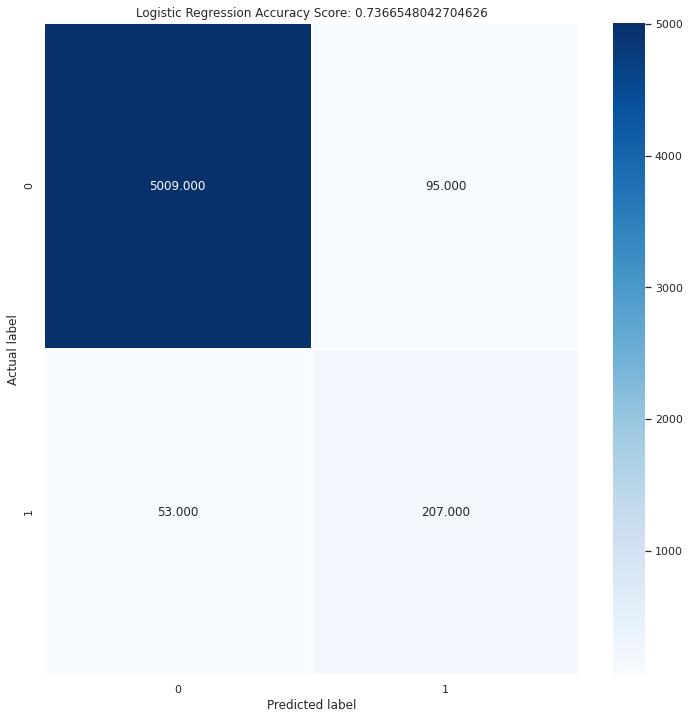

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression Accuracy Score: {0}'.format(log_bow_scores)
plt.title(title)

## Nhận xét
Từ biểu đồ trên, ta thấy:
- Có 5009 thông tin tuyển dụng (trong tập valid) dự đoán lớp 0 (không lừa đảo) đúng với thực tế.
- Có 207 thông tin tuyển dụng dự đoán lớp 1 (lừa đảo) đúng với thực tế.
- Bên cạnh đó, có 53 trường hợp báo nhầm (thực tế là không lừa đảo nhưng lại dự đoán là lừa đảo). Và 95 trường hợp BỎ SÓT - tức là thông tin tuyển dụng đó là lừa đảo nhưng ta lại nhận diện nó là không lừa đảo.


## Giải quyết:

#### Giả sử ta coi lớp 0 là lớp Positive và lớp 1 là Negative. Đặt câu hỏi là làm thế nào để tăng độ báo nhầm (FPR) để giảm mức độ bỏ sót (FNR).


### Tình huống 1: Nếu chúng ta chú trọng vào việc làm thế nào để khắc phục được tình trạng BỎ SÓT bài tuyển dụng lừa đảo xuống mức tối thiểu nhất có thể.
### Giải pháp: 
Ở dây ta sẽ sử dụng predict_proba thay vì predict. Tùy thuộc ta chọn ngưỡng, nếu chọn ngưỡng là 0.2 thì mọi dự đoán có xác suất đầu ra có ngưỡng lớn hơn 0.2 sẽ được dự đoán thuộc lớp Positive - lớp 0.
Ngược lại, nếu muốn bỏ sót còn hơn báo nhầm, ta chỉ cần tăng ngưỡng lớn hơn 0.5. Khi đó các điểm dữ liệu sẽ thuộc lớp 1 - lớp Negative.

In [ ]:
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_bow)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
log_bow_scores = f1_score(prediction_int, yvalid_bow)

In [ ]:
log_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'Logistic Regression Accuracy Score: 0.6921898928024502')

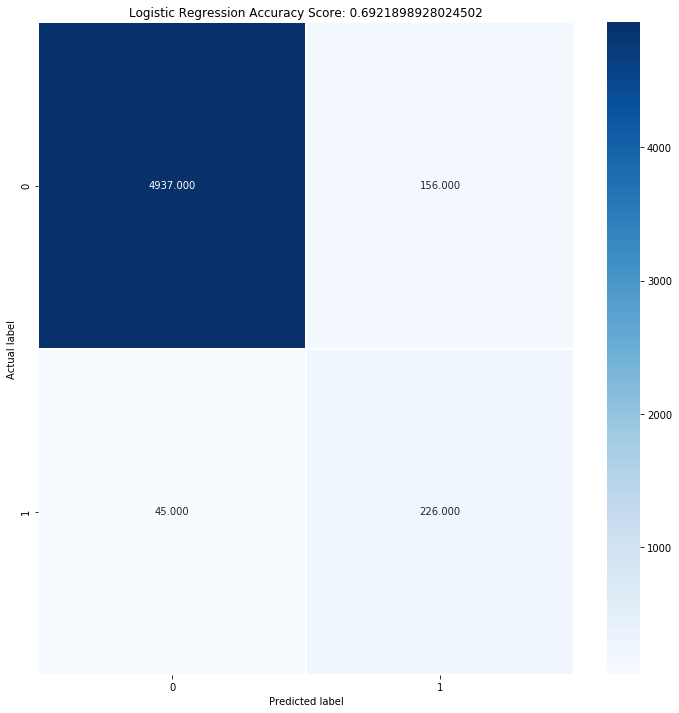

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression Accuracy Score: {0}'.format(log_bow_scores)
plt.title(title)

### Tình huống 2: Nếu chúng ta đặt bài toán kinh tế vào vấn đề này, ta sẽ mong muốn làm sao để công ty có thể thu đươc lợi nhuận một các tối đa, thì ta sẽ chấp nhận việc BÁO NHẦM - nghĩa là có thể bỏ qua những bài viết tuyển dụng lừa đảo.
### Giải pháp: 
Nếu muốn bỏ sót còn hơn báo nhầm, ta chỉ cần tăng ngưỡng lớn hơn 0.5, ở bài toán này nhóm tác giả chọn ngưỡng = 0.8. Khi đó các điểm dữ liệu sẽ thuộc lớp 1 - lớp Negative.

In [ ]:
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_bow)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
log_bow_scores = f1_score(prediction_int, yvalid_bow)

In [ ]:
log_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'Logistic Regression Accuracy Score: 0.7596899224806202')

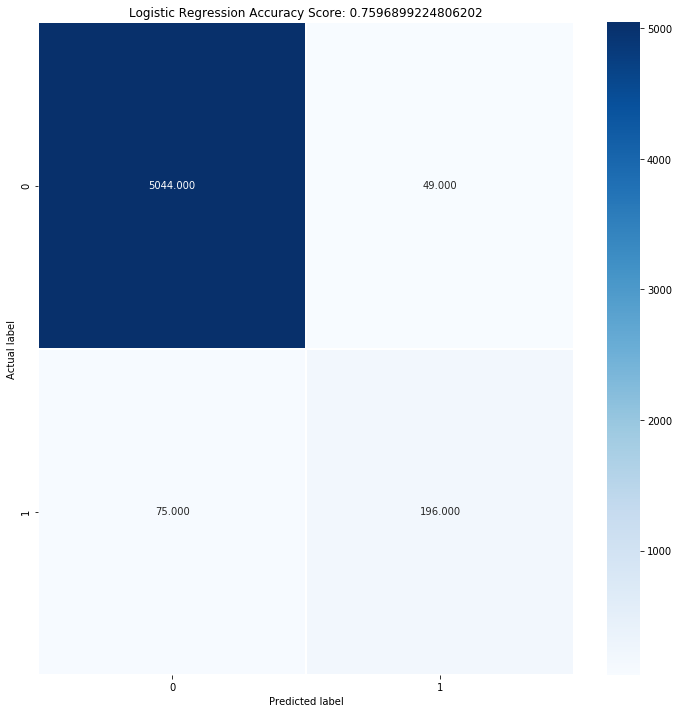

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression Accuracy Score: {0}'.format(log_bow_scores)
plt.title(title)

In [ ]:
#tfidf
lreg_start = time.time()
lreg = LogisticRegression().fit(Xtrain_tfidf, ytrain_tfidf)
lreg_end = time.time()

In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

In [ ]:
lreg_start = time.time()
pred_tfidf = lreg.predict(xvalid_tfidf)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

In [ ]:
log_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)

In [ ]:
log_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

Text(0.5, 1, 'Logistic Regression Accuracy Score: 0.8309352517985611')

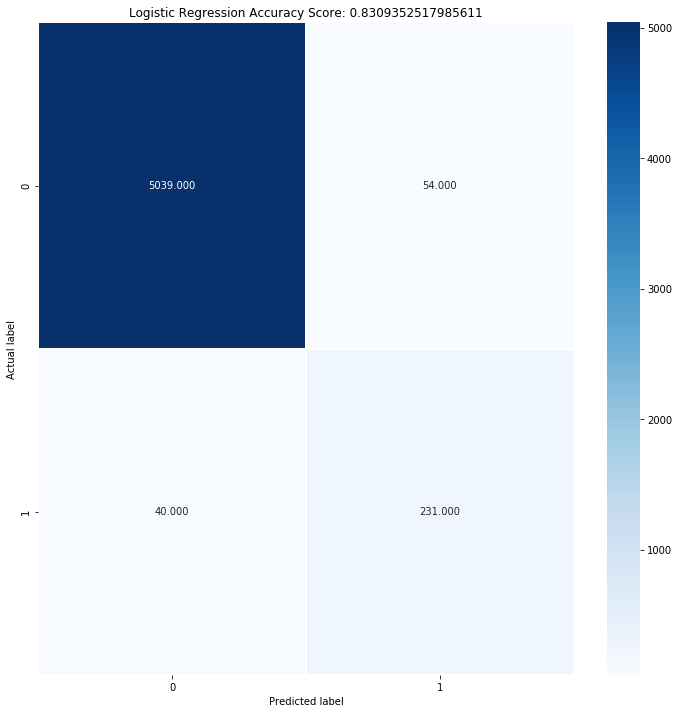

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression Accuracy Score: {0}'.format(log_tfidf_scores)
plt.title(title)

In [ ]:
# khắc phục tình trạng bỏ sót
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_tfidf)
lreg_end = time.time()
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
print(timedelta(seconds=round(lreg_end-lreg_start,5)))

In [ ]:
log_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)

In [ ]:
log_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1, 'Logistic Regression Accuracy Score: 0.5587583148558758')

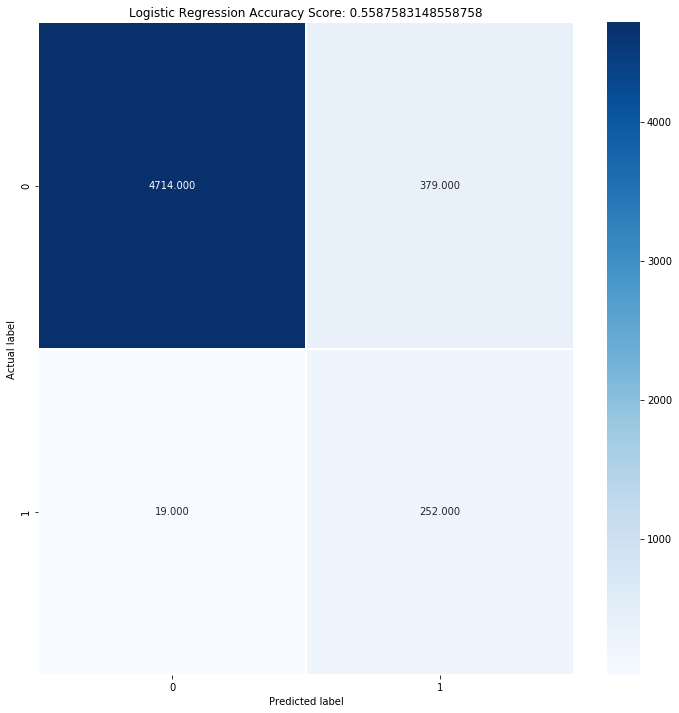

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression Accuracy Score: {0}'.format(log_tfidf_scores)
plt.title(title)

In [ ]:
#giảm báo nhầm
lreg_start = time.time()
prediction = lreg.predict_proba(xvalid_tfidf)
lreg_end = time.time()
print(timedelta(seconds=round(lreg_end-lreg_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
log_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)

In [ ]:
log_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1, 'Logistic Regression Accuracy Score: 0.8017057569296375')

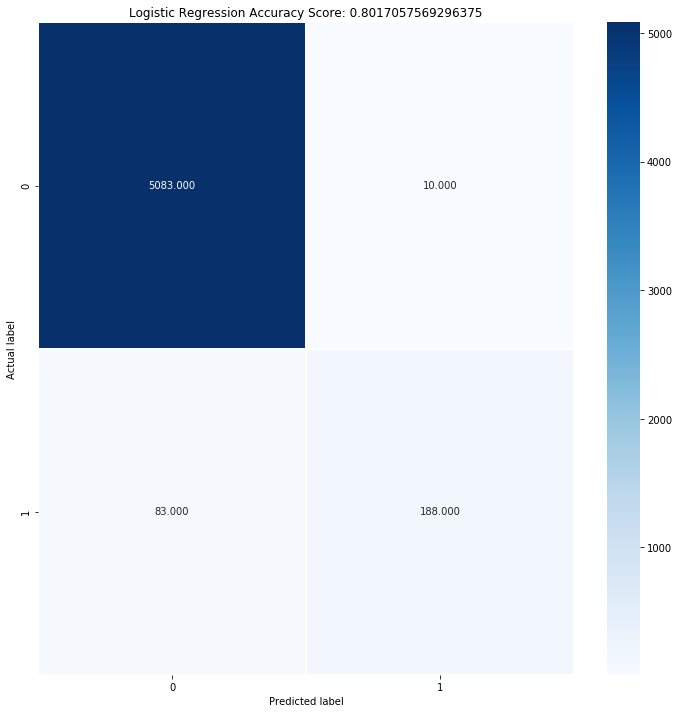

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(log_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Logistic Regression Accuracy Score: {0}'.format(log_tfidf_scores)
plt.title(title)

## Nhận xét:
- Đối với thuật toán Logistic Regression, ta sẽ sử dụng TFIDF vì nó cho kết quả dự đoán cao hơn.
- Độ chính xác của mô hình là 83%

### SVM

In [ ]:
#Bag of word
svm_start = time.time()
svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_bow, ytrain_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

In [ ]:
svm_start = time.time()
pred_bow = svc.predict(xvalid_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

In [ ]:
svm_bow_scores = f1_score(yvalid_bow, pred_bow)
svm_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1, 'SVM Accuracy Score: 0.7178571428571429')

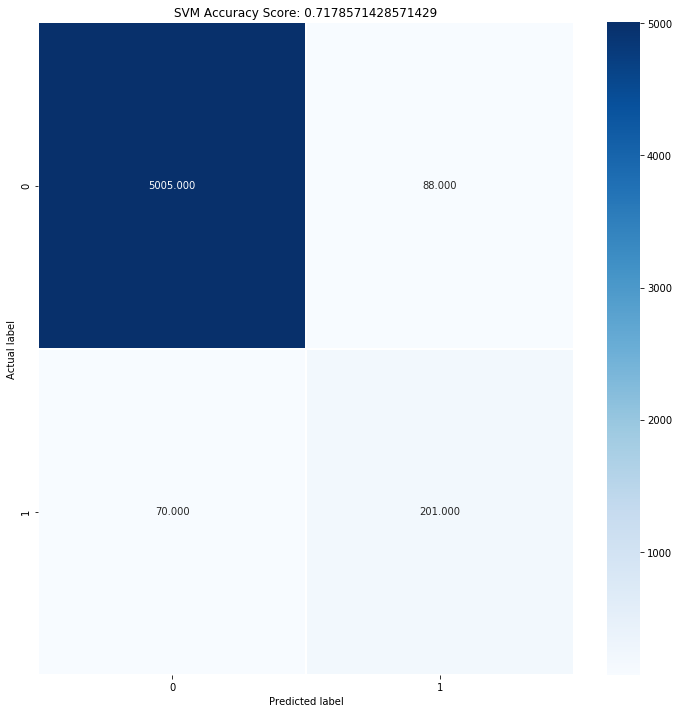

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM Accuracy Score: {0}'.format(svm_bow_scores)
plt.title(title)

In [ ]:
#Bỏ sót
svm_start = time.time()
prediction = svc.predict_proba(xvalid_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
svm_bow_scores = f1_score(prediction_int, yvalid_bow)
svm_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'SVM Accuracy Score: 0.6977491961414792')

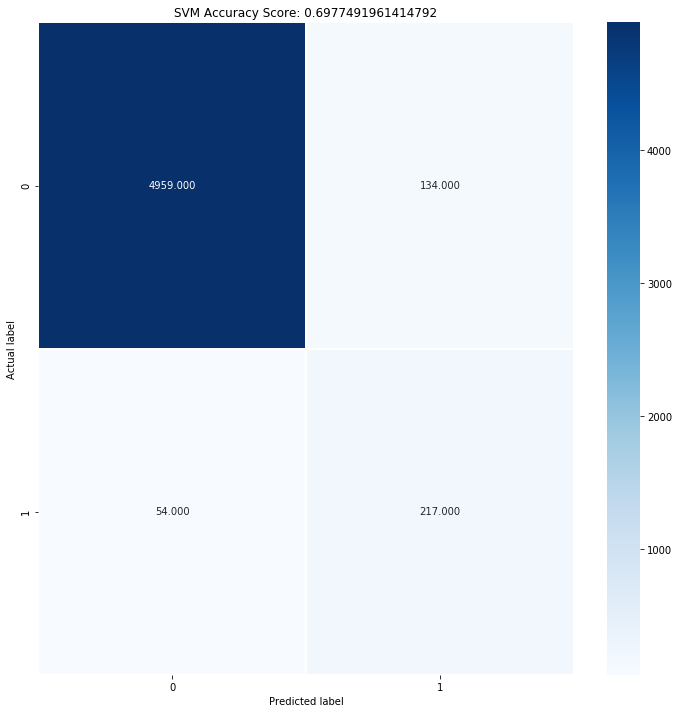

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM Accuracy Score: {0}'.format(svm_bow_scores)
plt.title(title)

In [ ]:
#Báo nhầm
svm_start = time.time()
prediction = svc.predict_proba(xvalid_bow)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
svm_bow_scores = f1_score(prediction_int, yvalid_bow)
svm_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'SVM Accuracy Score: 0.7387755102040816')

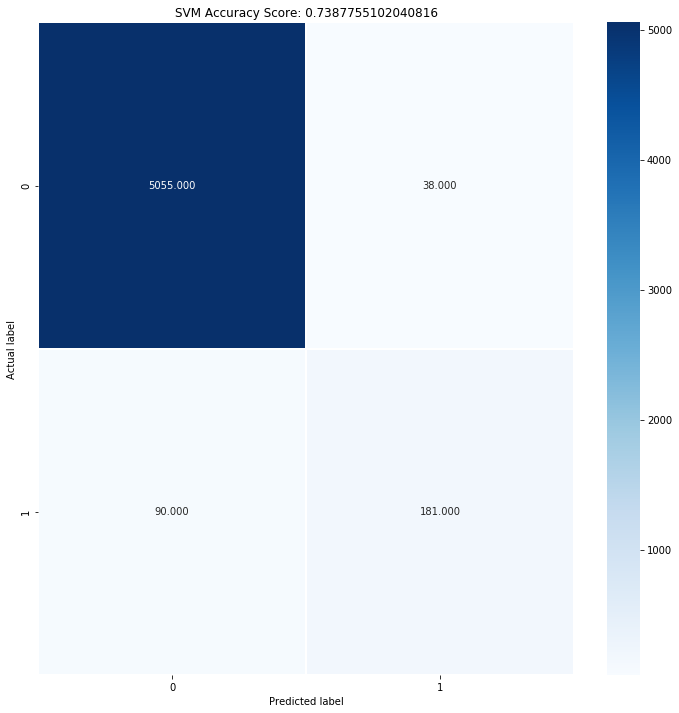

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM Accuracy Score: {0}'.format(svm_bow_scores)
plt.title(title)

In [ ]:
#TFIDF
svm_start = time.time()
svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_tfidf, ytrain_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

In [ ]:
svm_start = time.time()
pred_tfidf = svc.predict(xvalid_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

In [ ]:
svm_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)
svm_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

Text(0.5, 1, 'SVM Accuracy Score: 0.8433734939759037')

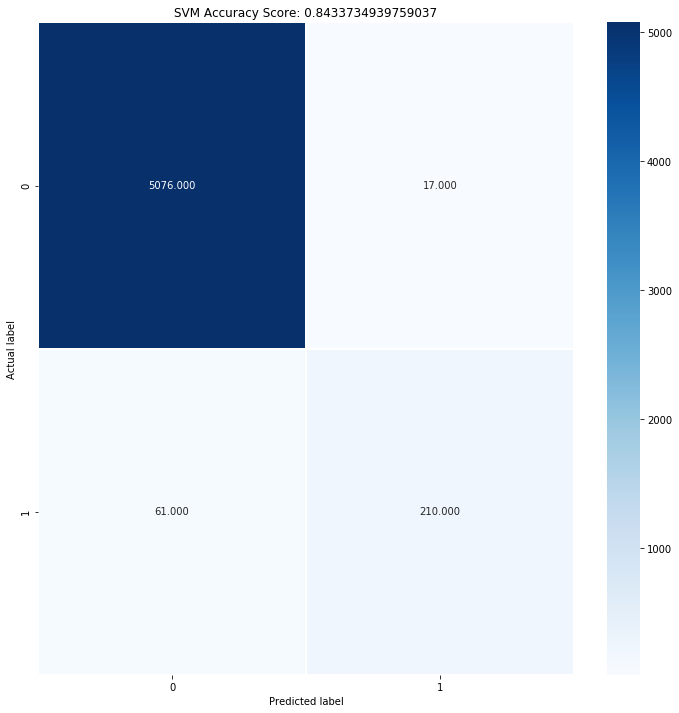

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM Accuracy Score: {0}'.format(svm_tfidf_scores)
plt.title(title)

In [ ]:
#Bỏ sót
svm_start = time.time()
prediction = svc.predict_proba(xvalid_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
svm_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
svm_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1, 'SVM Accuracy Score: 0.84472049689441')

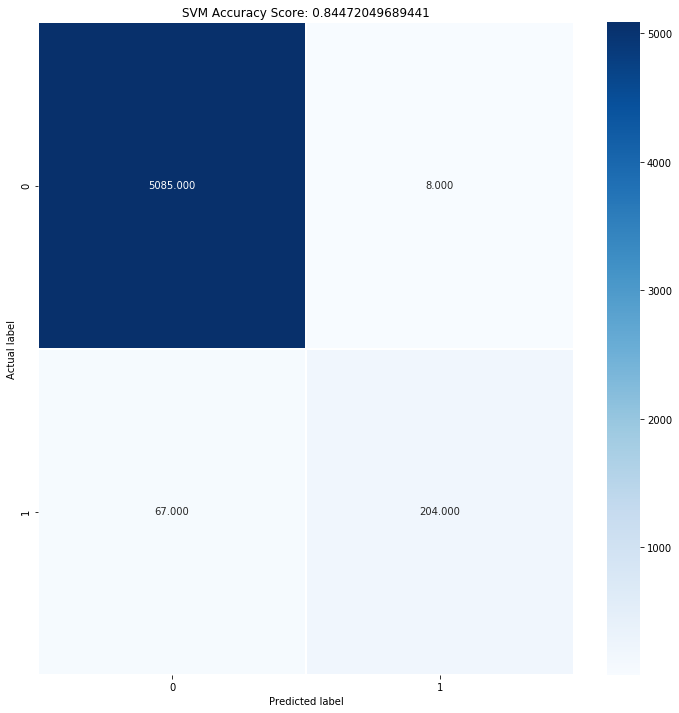

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM Accuracy Score: {0}'.format(svm_tfidf_scores)
plt.title(title)

In [ ]:
#Báo nhầm
svm_start = time.time()
prediction = svc.predict_proba(xvalid_tfidf)
svm_end = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
svm_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
svm_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1, 'SVM Accuracy Score: 0.8148148148148149')

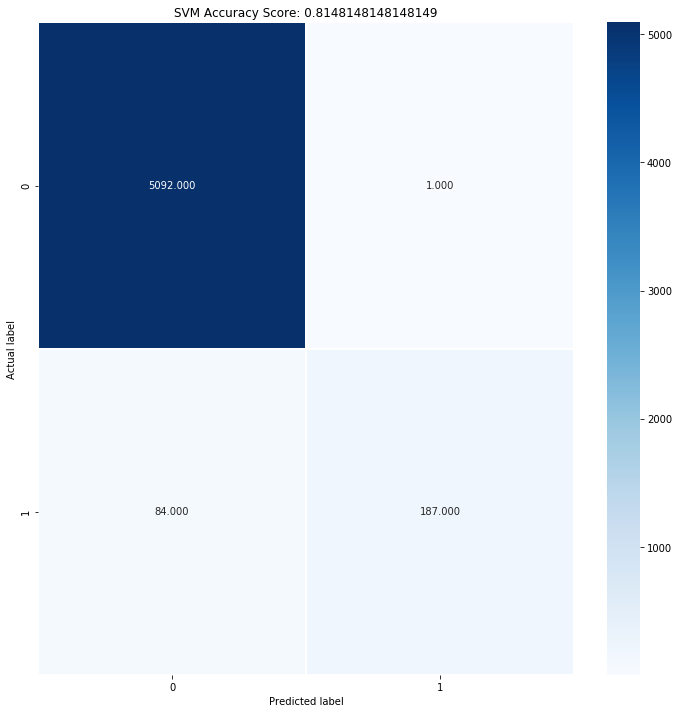

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(svm_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'SVM Accuracy Score: {0}'.format(svm_tfidf_scores)
plt.title(title)

## Nhận xét: 
- TFIDF vẫn cho kết quả dự đoán cao hơn BOW.
- Độ chính xác của mô hình là 84%

### Random Forest

In [ ]:
#Bag
rf_start = time.time()
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_bow, ytrain_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

In [ ]:
rf_start = time.time()
pred_bow = rf.predict(xvalid_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

In [ ]:
rf_bow_scores = f1_score(yvalid_bow, pred_bow)
rf_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1, 'Random Forest Accuracy Score: 0.7089108910891089')

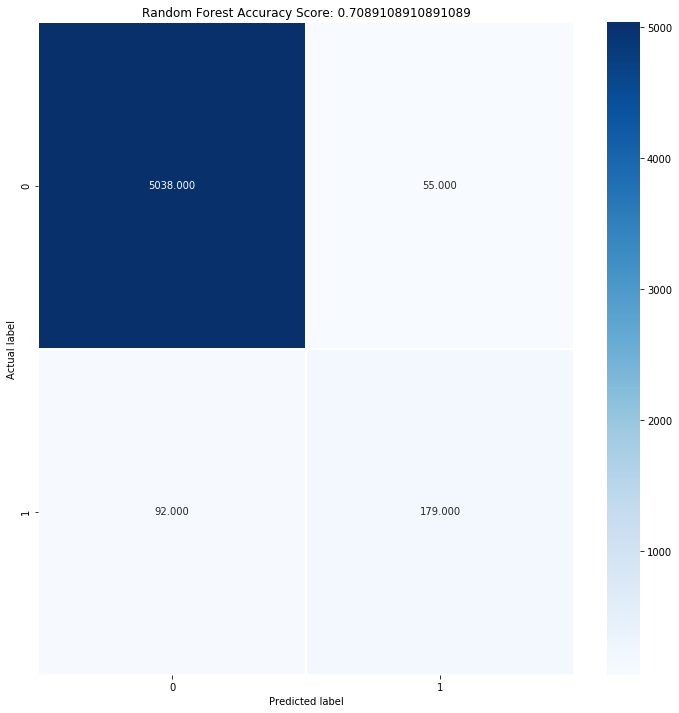

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score: {0}'.format(rf_bow_scores)
plt.title(title)

In [ ]:
#Bỏ sót
rf_start = time.time()
prediction = rf.predict_proba(xvalid_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
rf_bow_scores = f1_score(prediction_int, yvalid_bow)
rf_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'Random Forest Accuracy Score: 0.565864833906071')

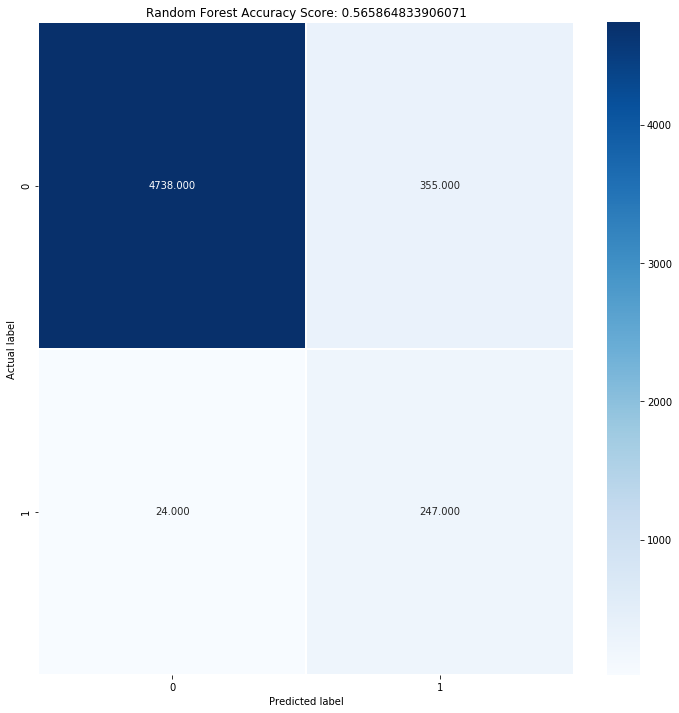

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score: {0}'.format(rf_bow_scores)
plt.title(title)

In [ ]:
#Báo nhầm
rf_start = time.time()
prediction = rf.predict_proba(xvalid_bow)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
rf_bow_scores = f1_score(prediction_int, yvalid_bow)
rf_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'Random Forest Accuracy Score: 0.606060606060606')

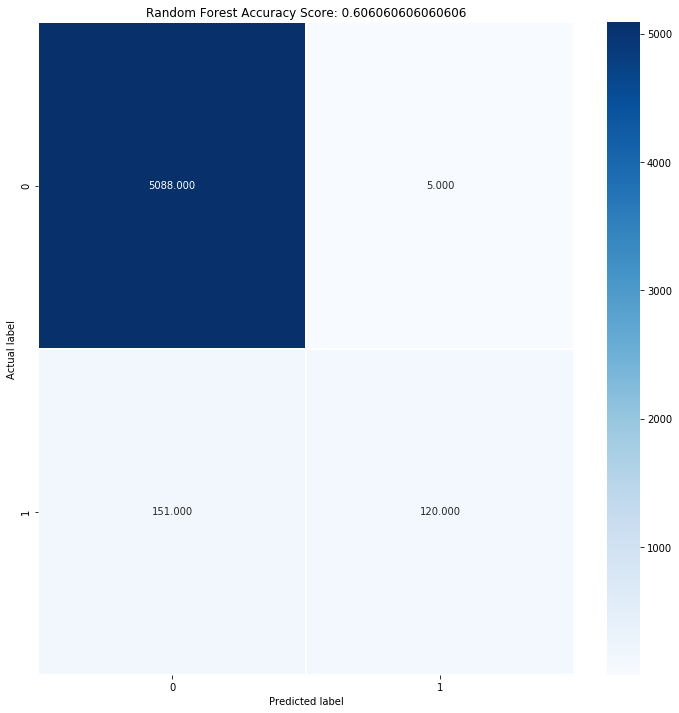

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score: {0}'.format(rf_bow_scores)
plt.title(title)

In [ ]:
#TFIDF
rf_start = time.time()
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_tfidf, ytrain_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

In [ ]:
rf_start = time.time()
pred_tfidf = rf.predict(xvalid_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

In [ ]:
rf_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)
rf_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score: {0}'.format(rf_tfidf_scores)
plt.title(title)

In [ ]:
#Bỏ sót
rf_start = time.time()
prediction = rf.predict_proba(xvalid_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
rf_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
rf_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1, 'Random Forest Accuracy Score: 0.09618456078083407')

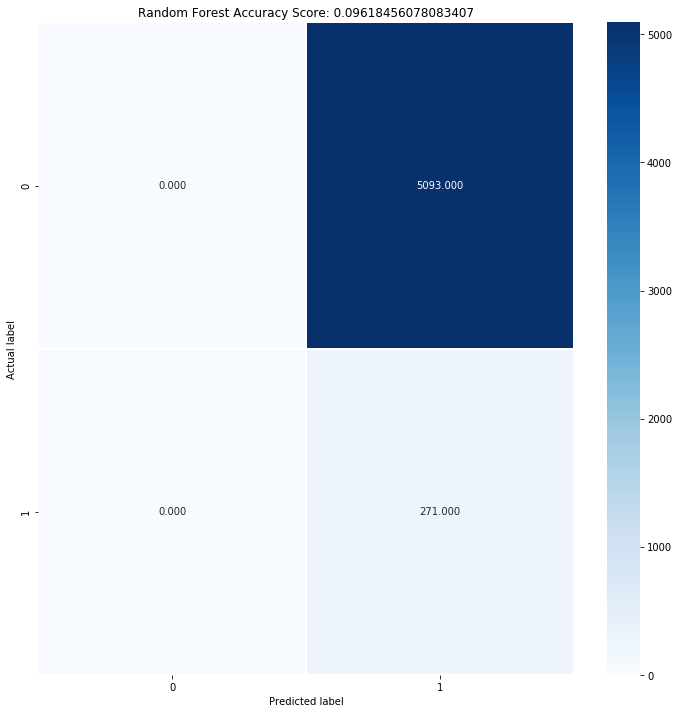

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score: {0}'.format(rf_tfidf_scores)
plt.title(title)

In [ ]:
#Báo nhầm
rf_start = time.time()
prediction = rf.predict_proba(xvalid_tfidf)
rf_end = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
rf_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
rf_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

Text(0.5, 1, 'SVM Accuracy Score: 0.09623579545454546')

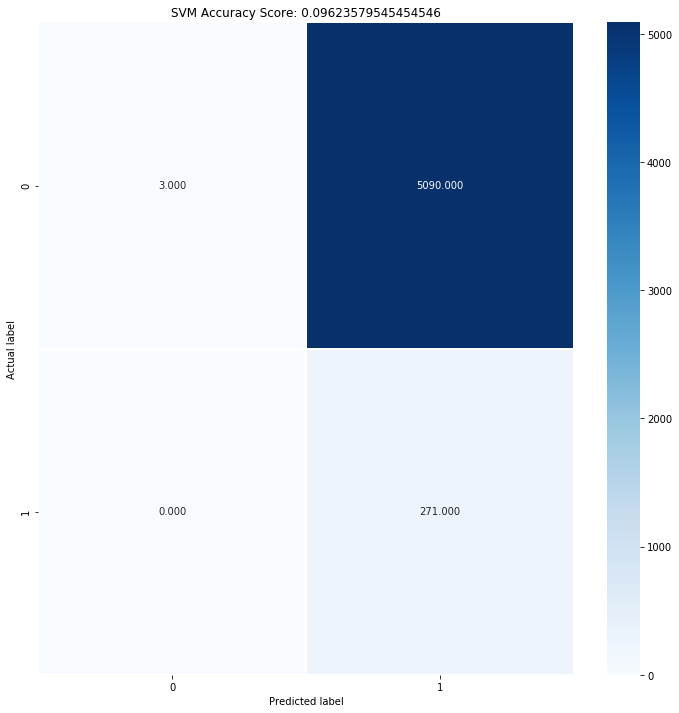

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(rf_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score: {0}'.format(rf_tfidf_scores)
plt.title(title)

## Nhận xét: 
- BOW cho kết quả dự đoán cao hơn TFIDF.
- Độ chính xác của mô hình là 71%

### XGBoost

In [ ]:
#BOW
xgb_start = time.time()
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(Xtrain_bow, ytrain_bow) 
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

In [ ]:
xgb_start = time.time()
pred_bow = xgb.predict(xvalid_bow)
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

In [ ]:
xgb_bow_scores = f1_score(yvalid_bow, pred_bow)
xgb_bow_cm = confusion_matrix(yvalid_bow, pred_bow)

Text(0.5, 1, 'XGBoost Forest Accuracy Score: 0.81104033970276')

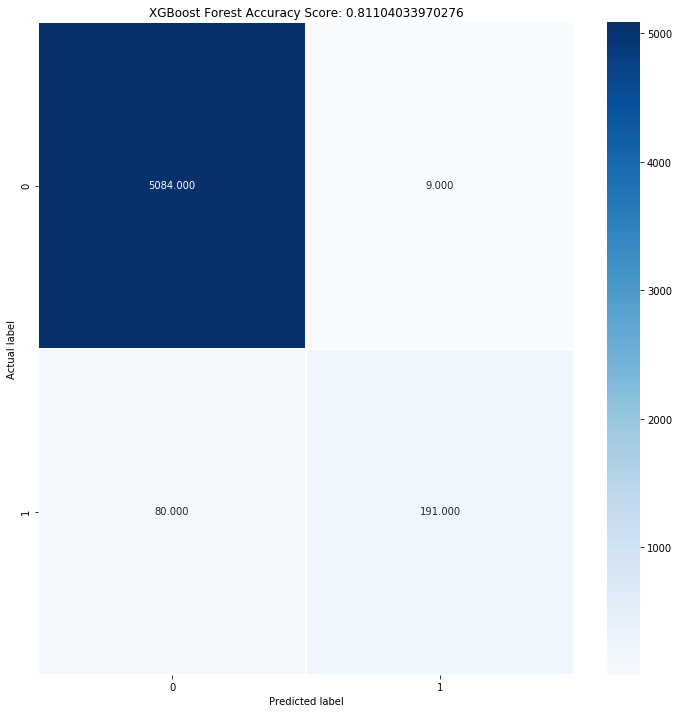

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(xgb_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score: {0}'.format(xgb_bow_scores)
plt.title(title)

In [ ]:
#Bỏ sót
xgb_start = time.time()
prediction = xgb.predict_proba(xvalid_bow)
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
xgb_bow_scores = f1_score(prediction_int, yvalid_bow)
xgb_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'XGBoost Accuracy Score: 0.836734693877551')

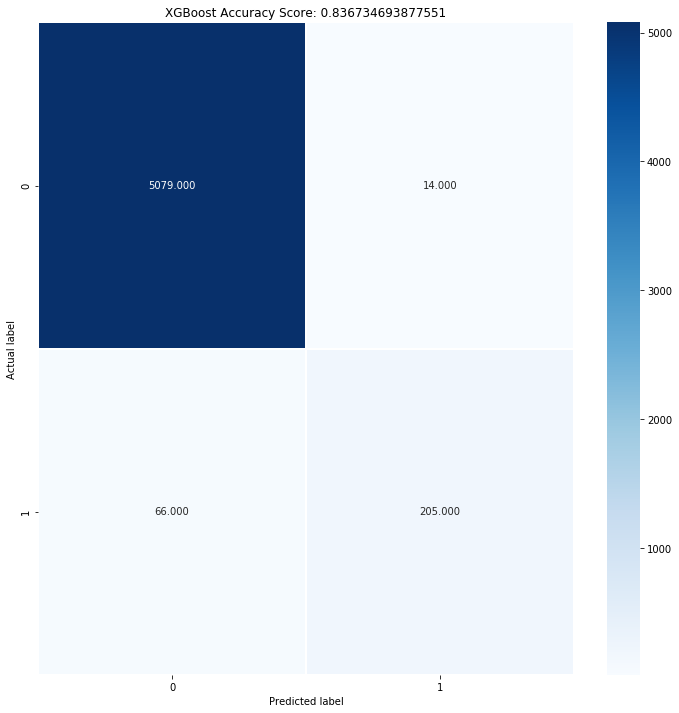

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(xgb_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score: {0}'.format(xgb_bow_scores)
plt.title(title)

In [ ]:
#Báo nhầm
xgb_start = time.time()
prediction = xgb.predict_proba(xvalid_bow)
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
xgb_bow_scores = f1_score(prediction_int, yvalid_bow)
xgb_bow_cm = confusion_matrix(yvalid_bow, prediction_int)

Text(0.5, 1, 'XGBoost Accuracy Score: 0.836734693877551')

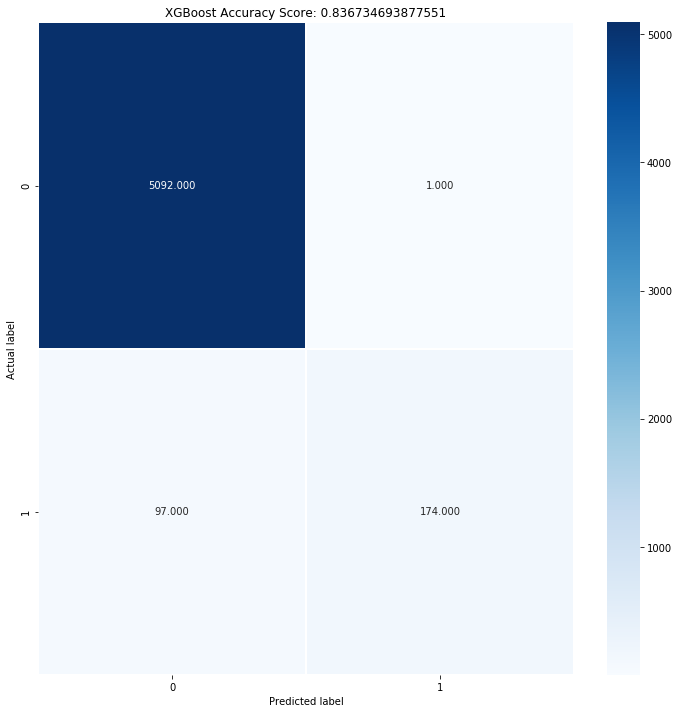

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(xgb_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score: {0}'.format(xgb_bow_scores)
plt.title(title)

In [ ]:
#TFIDF
xgb_start = time.time()
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(Xtrain_tfidf, ytrain_tfidf) 
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

In [ ]:
xgb_start = time.time()
pred_bow = xgb.predict(xvalid_tfidf)
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

In [ ]:
xgb_tfidf_scores = f1_score(yvalid_tfidf, pred_tfidf)
xgb_tfidf_cm = confusion_matrix(yvalid_tfidf, pred_tfidf)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(xgb_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score: {0}'.format(xgb_tfidf_scores)
plt.title(title)

In [ ]:
#Bỏ sót
xgb_start = time.time()
prediction = xgb.predict_proba(xvalid_tfidf)
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))
prediction_int = prediction[:,1] >=0.2
prediction_int =prediction_int.astype(np.int)

In [ ]:
xgb_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
xgb_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(xgb_bow_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score: {0}'.format(xgb_tfidf_scores)
plt.title(title)

In [ ]:
#Báo nhầm
xgb_start = time.time()
prediction = xgb.predict_proba(xvalid_tfidf)
xgb_end = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))
prediction_int = prediction[:,1] >=0.8
prediction_int =prediction_int.astype(np.int)

In [ ]:
xgb_tfidf_scores = f1_score(prediction_int, yvalid_tfidf)
xgb_tfidf_cm = confusion_matrix(yvalid_tfidf, prediction_int)

In [ ]:
# biểu diễn ma trận nhầm lẫn
plt.figure(figsize=(12,12))
sns.heatmap(xgb_tfidf_cm, linewidths=1, fmt='.3f', cmap='Blues', annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'XGBoost Accuracy Score: {0}'.format(xgb_tfidf_scores)
plt.title(title)

## Cross validation - StratifiedKFord

Cross-validation là kỹ thuật dùng để chia dữ liệu giữa các training sets và validation sets. Trên mỗi Cross-validation điển hình, việc này được thực hiện ngẫu nhiên. Nhưng trên Stratified Cross-validation việc này được thực hiện xấp xỉ nhau. Với ví dụ bài toán này, ta sử dụng Stratified thì sẽ có tỉ lệ tương tự giữa train và valid. Ngược lại nếu ta dùng cross-validatio điển hình, trường hợp xấu nhất thì ta sẽ không thấy lớp 1 trong valid set.

- fit() tính toán mean và std để sử dụng cho scale sau này.
- transform() sử dụng mean và std từ fit() để auto scale data (lấy tất cả giá trị trừ cho mean và chia cho std).
- fit_transform() fix cả 2 cái trên.
- Với trainning set, ta sử dụng fit_transform vì ta cần tính mean và std và sau đó sử dụng chúng để auto scale dữ liệu.
- Với testing set, ta đã có sẳn mean và std nên chỉ cần transform nó.


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
#bow - Logistic Regression
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = [] 
time_train_scores = []
time_pred_scores = []  
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    

    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)
    
    lreg_start = time.time()
    lreg = LogisticRegression().fit(Xtrain_bow, Ytrain_bow)
    lreg_end = time.time()
    time_train = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    lreg_start = time.time()
    preds = lr.predict(test_X_vec)
    lreg_end = time.time()
    time_pred = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    time_train_scores.append(time_train)
    time_pred_scores.append(time_pred)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5


C:\Users\Hang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1_score of Fold 1: 0.7630057803468208
2 of KFold 5


C:\Users\Hang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1_score of Fold 2: 0.7421052631578947
3 of KFold 5


C:\Users\Hang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1_score of Fold 3: 0.7241379310344828
4 of KFold 5


C:\Users\Hang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1_score of Fold 4: 0.7365728900255754
5 of KFold 5
F1_score of Fold 5: 0.7545219638242894
Mean f1_score = 0.74


C:\Users\Hang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#tfidf - Logistic Regression
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []  
time_train_scores = []
time_pred_scores = []   
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)
    
    lreg_start = time.time()
    lreg = LogisticRegression().fit(Xtrain_bow, Ytrain_bow)
    lreg_end = time.time()
    time_train = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    lreg_start = time.time()
    preds = lr.predict(test_X_vec)
    lreg_end = time.time()
    time_pred = timedelta(seconds=round(lreg_end - lreg_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5
F1_score of Fold 1: 0.7833333333333333
2 of KFold 5
F1_score of Fold 2: 0.8291316526610644
3 of KFold 5
F1_score of Fold 3: 0.7727272727272726
4 of KFold 5
F1_score of Fold 4: 0.8108108108108107
5 of KFold 5
F1_score of Fold 5: 0.7798408488063661
Mean f1_score = 0.80


In [ ]:
#bow - SVM
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []   
time_train_scores = []
time_pred_scores = []  
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    svm_start = time.time()
    svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_bow, Ytrain_bow)
    svm_end = time.time()
    time_train = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    svm_start = time.time()
    preds = svc.predict(test_X_vec)
    svm_end = time.time()
    time_pred = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5
F1_score of Fold 1: 0.7401129943502825
2 of KFold 5
F1_score of Fold 2: 0.7310704960835509
3 of KFold 5
F1_score of Fold 3: 0.6797752808988764
4 of KFold 5
F1_score of Fold 4: 0.74934036939314
5 of KFold 5
F1_score of Fold 5: 0.7362924281984333
Mean f1_score = 0.73


In [ ]:
#tfidf - SVM
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = [] 
time_train_scores = []
time_pred_scores = []    
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    svm_start = time.time()
    svc = SVC(kernel='linear', C=1, probability=True).fit(Xtrain_bow, Ytrain_bow)
    svm_end = time.time()
    time_train = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    svm_start = time.time()
    preds = svc.predict(test_X_vec)
    svm_end = time.time()
    time_pred = timedelta(seconds=round(svm_end - svm_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5
F1_score of Fold 1: 0.8282208588957055
2 of KFold 5
F1_score of Fold 2: 0.8580246913580247
3 of KFold 5
F1_score of Fold 3: 0.8113207547169811
4 of KFold 5
F1_score of Fold 4: 0.8511904761904763
5 of KFold 5
F1_score of Fold 5: 0.8454810495626823
Mean f1_score = 0.84


In [ ]:
#bow - Random Forest
from sklearn.ensemble import RandomForestClassifier
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []
time_train_scores = []
time_pred_scores = []     
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)
   
    rf_start = time.time()
    rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_bow, Ytrain_bow)
    rf_start = time.time()
    time_train = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    rf_start = time.time()
    preds = rf.predict(test_X_vec)
    rf_start = time.time()
    time_pred = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5
F1_score of Fold 1: 0.7392739273927392
2 of KFold 5
F1_score of Fold 2: 0.7477744807121661
3 of KFold 5
F1_score of Fold 3: 0.6709265175718849
4 of KFold 5
F1_score of Fold 4: 0.7223880597014924
5 of KFold 5
F1_score of Fold 5: 0.752136752136752
Mean f1_score = 0.73


In [ ]:
#tfidf - Random Forest
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []  
time_train_scores = []
time_pred_scores = []   
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    rf_start = time.time()
    rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(Xtrain_bow, Ytrain_bow)
    rf_end = time.time()
    time_train = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    rf_start = time.time()
    preds = rf.predict(test_X_vec)
    rf_end = time.time()
    time_pred = timedelta(seconds=round(rf_end - rf_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5
F1_score of Fold 1: 0.7482014388489209
2 of KFold 5
F1_score of Fold 2: 0.7553956834532374
3 of KFold 5
F1_score of Fold 3: 0.7205882352941178
4 of KFold 5
F1_score of Fold 4: 0.8095238095238095
5 of KFold 5
F1_score of Fold 5: 0.8054607508532422
Mean f1_score = 0.77


In [ ]:
from xgboost import XGBClassifier

In [ ]:
#bow - XGBoost
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = [] 
time_train_scores = []
time_pred_scores = []    
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = bow_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = bow_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    xgb_start = time.time()
    xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(Xtrain_bow, Ytrain_bow)
    xgb_start = time.time()
    time_train = timedelta(seconds=round(xgb_end - xgb_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    xgb_start = time.time()
    preds = xgb.predict(test_X_vec)
    xgb_start = time.time()
    time_pred = timedelta(seconds=round(xgb_end - xgb_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))
print('Mean time training = {:.2f}'.format(np.mean(time_train_scores)))
print('Mean time predict = {:.2f}'.format(np.mean(time_pred_scores)))

1 of KFold 5
F1_score of Fold 1: 0.8092105263157896
2 of KFold 5
F1_score of Fold 2: 0.8145695364238411
3 of KFold 5
F1_score of Fold 3: 0.7835051546391752
4 of KFold 5
F1_score of Fold 4: 0.8516129032258064
5 of KFold 5
F1_score of Fold 5: 0.832258064516129
Mean f1_score = 0.82


In [ ]:
#tfidf - XGBoost
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
cv_scores = []   
time_train_scores = []
time_pred_scores = []  
i = 1
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(df.tidy_text, df.fraudulent):
    print('{} of KFold {}'.format(i, kfold.n_splits))
    xtrain_bow, xvalid_bow = df.tidy_text[train_ix], df.tidy_text[test_ix]
    ytrain_bow, yvalid_bow = df.fraudulent[train_ix], df.fraudulent[test_ix]

    # Appling Count Vectorizer
    train_X_vec = tfidf_vectorizer.fit_transform(xtrain_bow)
    test_X_vec = tfidf_vectorizer.transform(xvalid_bow)    
    
    sm = SMOTE(random_state = 42)
    Xtrain_bow, Ytrain_bow = sm.fit_sample(train_X_vec, ytrain_bow)

    xgb_start = time.time()
    xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(Xtrain_bow, Ytrain_bow)
    xgb_end = time.time()
    time_train = timedelta(seconds=round(xgb_end - xgb_start,5))
    print('Time training of Fold {}:{}'.format(i,time_train))

    xgb_start = time.time()
    preds = xgb.predict(test_X_vec)
    xgb_end = time.time()
    time_pred = timedelta(seconds=round(xgb_end - xgb_start,5))
    print('Time predict of Fold {}:{}'.format(i,time_pred))
    
    scores = f1_score(yvalid_bow, preds)
    print('F1_score of Fold {}: {}'.format(i, scores))
    cv_scores.append(scores)
    i += 1

print('Mean f1_score = {:.2f}'.format(np.mean(cv_scores)))

1 of KFold 5
F1_score of Fold 1: 0.802588996763754
2 of KFold 5
F1_score of Fold 2: 0.8246753246753246
3 of KFold 5
F1_score of Fold 3: 0.7864406779661016
4 of KFold 5
F1_score of Fold 4: 0.8695652173913044
5 of KFold 5
F1_score of Fold 5: 0.8461538461538461
Mean f1_score = 0.83


### Hyperparameter Tuning GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                  stratify=df.fraudulent)

In [ ]:
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf,df.fraudulent, random_state= 42, test_size=0.3,\
                                                                          stratify=df.fraudulent)

In [ ]:
#bow - Logisstic
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Logistic Regression
parameter_candidates = [0.001,0.01,0.1,1,10,100]
# Thực hiện Over Sampling
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(Xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.

lreg_start = time.time()
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_bow, Ytrain_bow)
lreg_start = time.time()
print(timedelta(seconds=round(lreg_end - lreg_start,5)))

# dự đoán tập valid
lreg_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_bow)
lreg_start = time.time()
print(timedelta(seconds=round(lreg_end - lreg_start,5)))
# Tính ma trận nhầm lẫn
lreg_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, lreg_cm in zip(means, params, lreg_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', svm_clreg_cmm)

In [ ]:
#tfidf - Logisstic
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Logistic Regression
parameter_candidates = [0.001,0.01,0.1,1,10,100]
# Thực hiện Over Sampling   
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(Xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
lreg_start = time.time()
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_tfidf, Ytrain_tfidf)
lreg_start = time.time()
print(timedelta(seconds=round(lreg_end - lreg_start,5)))

# dự đoán tập valid
lreg_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_tfidf)
lreg_start = time.time()
print(timedelta(seconds=round(lreg_end - lreg_start,5)))
# Tính ma trận nhầm lẫn
lreg_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, svmlreg_cm_cm in zip(means, params, lreg_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', lreg_cm)

In [ ]:
#bow - SVM
# Sử dụng GridSearchCV để tuning hyper-parameter cho SVM
parameter_candidates = [{'C':[1, 5, 10], 'kernel':['linear', 'rbf', 'poly']}]
# Thực hiện Over Sampling   
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(Xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
svm_start = time.time()
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_bow, Ytrain_bow)
svm_start = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
 
# dự đoán tập valid
svm_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_bow)
svm_start = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
# Tính ma trận nhầm lẫn
svm_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, svm_cm in zip(means, params, svm_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', svm_cm)

In [ ]:
#TFIDF - SVM
# Sử dụng GridSearchCV để tuning hyper-parameter cho SVM
parameter_candidates = [{'C':[1, 5, 10], 'kernel':['linear', 'rbf', 'poly']}]
# Thực hiện Over Sampling
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(Xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác. 
svm_start = time.time()
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_tfidf, Ytrain_tfidf)
svm_start = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))

# dự đoán tập valid
svm_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_tfidf)
svm_start = time.time()
print(timedelta(seconds=round(svm_end - svm_start,5)))
# Tính ma trận nhầm lẫn
svm_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, svm_cm in zip(means, params, svm_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', svm_cm)

In [ ]:
#bow - Random Forest
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Random Forest
parameter_candidates = {'bootstrap': [True, False],
 'max_depth': [10, 30, 50, 70, 90],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [600, 1000, 1400, 1800, 2000]}
# Thực hiện Over Sampling  
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(Xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
rf_start = time.time()
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_bow, Ytrain_bow)
rf_start = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

# dự đoán tập valid
rf_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_bow)
rf_start = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

# Tính ma trận nhầm lẫn
rf_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, rf_cm in zip(means, params, rf_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', rf_cm)

In [ ]:
#TFIDF - Random Forest
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán Random Forest
parameter_candidates = {'bootstrap': [True, False],
 'max_depth': [10, 30, 50, 70, 90],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [600, 1000, 1400, 1800, 2000]}
# Thực hiện Over Sampling  
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(Xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác. 
rf_start = time.time()
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_tfidf, Ytrain_tfidf)
rf_start = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

# dự đoán tập valid
rf_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_tfidf)
rf_start = time.time()
print(timedelta(seconds=round(rf_end - rf_start,5)))

# Tính ma trận nhầm lẫn
rf_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, rf_cm in zip(means, params, rf_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', rf_cm)

In [ ]:
#bow - XGBoost
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
# Thực hiện Over Sampling
sm = SMOTE(random_state = 42)
Xtrain_bow, Ytrain_bow = sm.fit_sample(Xtrain_bow, ytrain_bow)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
xgb_start = time.time()
clf = GridSearchCV(estimator=XGBClassifier(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_bow, Ytrain_bow)
xgb_start = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

# dự đoán tập valid
xgb_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_bow)
xgb_start = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

# Tính ma trận nhầm lẫn
xgb_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, xgb_cm in zip(means, params, xgb_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', xgb_cm)

In [ ]:
#TFIDF - XGBoost
# Sử dụng GridSearchCV để tuning hyper-parameter cho thuật toán XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
# Thực hiện Over Sampling  
sm = SMOTE(random_state = 42)
Xtrain_tfidf, Ytrain_tfidf = sm.fit_sample(Xtrain_tfidf, ytrain_tfidf)
# Chọn scoring = 'f1-score' làm độ đo. Bạn có thể thay thể bằng các độ đo khác.
xgb_start = time.time()
clf = GridSearchCV(estimator=XGBClassifier(), param_grid=parameter_candidates, scoring='f1_macro').fit(Xtrain_tfidf, Ytrain_tfidf)
xgb_start = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

# dự đoán tập valid
xgb_start = time.time()
y_pred = clf.best_estimator_.predict(xvalid_tfidf)
xgb_start = time.time()
print(timedelta(seconds=round(xgb_end - xgb_start,5)))

# Tính ma trận nhầm lẫn
xgb_cm = confusion_matrix(yvalid, y_pred)

print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
params = clf.cv_results_['params']

for mean, param, xgb_cm in zip(means, params, xgb_cm):
  print("%f with: %r" % (mean, param))
  print('Confusion matrix:', xgb_cm)